In [1]:
# The programming language we are using is python
# We require the use of some functions not already part of this language
# Instead of writing them from scratch, we can import them as part of external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
from sklearn.model_selection import train_test_split
import shutil
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# This specifies the file containing relevant data from my hard drive
data = pd.read_csv("C:/Users/natha/Desktop/MSCi/algae.csv")

In [3]:
# We will preview the first 5 examples in our dataset
data.head()

,Gene,Average,Normalised avg,3UTR,5UTR,Quintile,Tertile,3UTR MFE,3UTRL
0,atpA,11.88,0.832,tttttaattaagtaggaactcggtatatgctcttttggggtcttat...,attttaatgcttatgctatcttttttatttagtccataaaaccttt...,5,3,-31.3,185
1,atpB,11.62,0.814,ttggctctttaagaagaaaacaacttaatggtgtccaaatatttat...,tcatattttaacttattttacttaaattcttacgtataaaccccga...,5,3,-4.9,70
2,atpE,11.36,0.796,ttagatctatgtatttacccaaagagtatactgttcaactctatca...,aataaaaaaaaataaaacttctaaaagcgataaagctagaacattc...,4,3,-30.1,132
3,atpF,9.68,0.678,tttttaataaagcttactaacgaattacactaactttactgtattt...,aaataaatttgacttagcttaaatttcagtatatttatatacacaa...,3,2,-230.6,628
4,atpH,13.85,0.971,ttttaaatttacatgttgtaaaggatatctatagaaatgggagtta...,tcggataaaacatattatgaccgtataatgtttttccaccattgaa...,5,3,-206.4,986


In [4]:
# An overview of the dataset, confirming we have no empty entries ("0 non-null")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene            67 non-null     object 
 1   Average         67 non-null     float64
 2   Normalised avg  67 non-null     float64
 3   3UTR            67 non-null     object 
 4   5UTR            67 non-null     object 
 5   Quintile        67 non-null     int64  
 6   Tertile         67 non-null     int64  
 7   3UTR MFE        67 non-null     float64
 8   3UTRL           67 non-null     int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 4.8+ KB


In [5]:
# These are the column headers of our dataset
data.keys()

Index(['Gene', 'Average', 'Normalised avg', '3UTR', '5UTR', 'Quintile',
       'Tertile', '3UTR MFE', '3UTRL'],
      dtype='object')

In [6]:
print(f"The dataset contains {data['Gene'].count()} chloroplast genes")

The dataset contains 67 chloroplast genes


In [7]:
# As the total number of genes is not divisible by 3, the tertiles are not equally sized
print('This is the number of examples of each tertile')
data["Tertile"].groupby(data['Tertile']).value_counts()

This is the number of examples of each tertile


Tertile  Tertile
1        1          22
2        2          22
3        3          23
Name: Tertile, dtype: int64

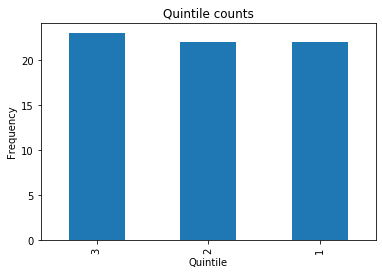

In [8]:
# A graphical representation of this
data['Tertile'].value_counts().plot(kind='bar').set(xlabel="Quintile", ylabel="Frequency", title="Quintile counts");

In [9]:
# On the plus side, we have a well-balanced dataset :)

In [10]:
# This function will divide our sequences into smaller lengths called k-mers for easier processing

def kmerconvert (sequence, k_length):
    k_conversion = []
    num_kmers = len(sequence) - k_length + 1
    
    for element in range(num_kmers):
        kmer = sequence[element:element + k_length]
        k_conversion.append(kmer)
        
    return k_conversion

In [11]:
# Applying the above function to our 3' regions
data['3UTRK'] = data.apply(lambda x: kmerconvert(x['3UTR'], k_length=3), axis=1)

In [12]:
# Applying the above function to our 5' regions
data['5UTRK'] = data.apply(lambda x: kmerconvert(x['5UTR'], k_length=3), axis=1)

In [13]:
# The addition of 2 columns to our dataset, 3UTRK and 5UTRK, can be seen here
data.head()

,Gene,Average,Normalised avg,3UTR,5UTR,Quintile,Tertile,3UTR MFE,3UTRL,3UTRK,5UTRK
0,atpA,11.88,0.832,tttttaattaagtaggaactcggtatatgctcttttggggtcttat...,attttaatgcttatgctatcttttttatttagtccataaaaccttt...,5,3,-31.3,185,"[ttt, ttt, ttt, tta, taa, aat, att, tta, taa, ...","[att, ttt, ttt, tta, taa, aat, atg, tgc, gct, ..."
1,atpB,11.62,0.814,ttggctctttaagaagaaaacaacttaatggtgtccaaatatttat...,tcatattttaacttattttacttaaattcttacgtataaaccccga...,5,3,-4.9,70,"[ttg, tgg, ggc, gct, ctc, tct, ctt, ttt, tta, ...","[tca, cat, ata, tat, att, ttt, ttt, tta, taa, ..."
2,atpE,11.36,0.796,ttagatctatgtatttacccaaagagtatactgttcaactctatca...,aataaaaaaaaataaaacttctaaaagcgataaagctagaacattc...,4,3,-30.1,132,"[tta, tag, aga, gat, atc, tct, cta, tat, atg, ...","[aat, ata, taa, aaa, aaa, aaa, aaa, aaa, aaa, ..."
3,atpF,9.68,0.678,tttttaataaagcttactaacgaattacactaactttactgtattt...,aaataaatttgacttagcttaaatttcagtatatttatatacacaa...,3,2,-230.6,628,"[ttt, ttt, ttt, tta, taa, aat, ata, taa, aaa, ...","[aaa, aat, ata, taa, aaa, aat, att, ttt, ttg, ..."
4,atpH,13.85,0.971,ttttaaatttacatgttgtaaaggatatctatagaaatgggagtta...,tcggataaaacatattatgaccgtataatgtttttccaccattgaa...,5,3,-206.4,986,"[ttt, ttt, tta, taa, aaa, aat, att, ttt, tta, ...","[tcg, cgg, gga, gat, ata, taa, aaa, aaa, aac, ..."


In [14]:
# This creates a new column containing both 3' and 5' UTR sequence information
data["Combined"] = data["3UTRK"] + data["5UTRK"]

In [15]:
# This function changes the way the k-mers are stored so they can be read together
kmer_sentences = list(data['Combined'])
for e in range(len(kmer_sentences)):
    kmer_sentences[e] = ' '.join(kmer_sentences[e])

In [35]:
# An example of how the k-mers look
print(kmer_sentences[5])

taa aaa aag agt gtt tta taa aat ata taa aag aga gat att ttt ttt tta taa aat att ttt tta taa aag agt gtt ttc tct cta tat ata tat att tta tat atc tca caa aac act cta tac act ctt tta tac act cta tag agt gtt ttg tga gat ata taa aat ata tat ata tag aga gaa aac act ctt tta taa aaa aat ata tat ata taa aaa aaa aag agt gtt ttt ttt tta taa aat att ttt ttt ttt ttc tct ctt tta taa aat ata tat atg tgt gta tag agt gtt ttg tgg ggc gca cag agt gtt tta tat att ttc tct cta taa aaa aat att tta taa aaa aac act cta tag agg ggt gta taa aaa aaa aag aga gat att ttt ttc tca cac act ctt ttc tct ctt ttt ttt tta tag agc gct cta tag aga gaa aaa aaa aaa aaa aaa aag aga aaa aaa aaa aat atg tgt gta taa aat ata taa aaa aaa aat att ttc tct ctt tta tac acc cca caa aat att tta tat att ttg tgg gga gaa aaa aag aga gat ata tat att tta taa aat ata tat att ttt ttt ttt tta taa aat ata taa aat ata taa aac acc cca cac act cta tat ata taa aaa aat ata taa aat atg tga gac acc cca cag agt gtt tta tat att tta tat atc tct cta tat att 

In [17]:
# This will now count the frequency of each k-mer in the UTR data, to see what is most common
cv = CountVectorizer(ngram_range=(8,8))
X = cv.fit_transform(kmer_sentences)
print(X.shape)

(67, 29911)


In [18]:
# The combined column contains our sequence information ready to be analysed by our model
data.head()

,Gene,Average,Normalised avg,3UTR,5UTR,Quintile,Tertile,3UTR MFE,3UTRL,3UTRK,5UTRK,Combined
0,atpA,11.88,0.832,tttttaattaagtaggaactcggtatatgctcttttggggtcttat...,attttaatgcttatgctatcttttttatttagtccataaaaccttt...,5,3,-31.3,185,"[ttt, ttt, ttt, tta, taa, aat, att, tta, taa, ...","[att, ttt, ttt, tta, taa, aat, atg, tgc, gct, ...","[ttt, ttt, ttt, tta, taa, aat, att, tta, taa, ..."
1,atpB,11.62,0.814,ttggctctttaagaagaaaacaacttaatggtgtccaaatatttat...,tcatattttaacttattttacttaaattcttacgtataaaccccga...,5,3,-4.9,70,"[ttg, tgg, ggc, gct, ctc, tct, ctt, ttt, tta, ...","[tca, cat, ata, tat, att, ttt, ttt, tta, taa, ...","[ttg, tgg, ggc, gct, ctc, tct, ctt, ttt, tta, ..."
2,atpE,11.36,0.796,ttagatctatgtatttacccaaagagtatactgttcaactctatca...,aataaaaaaaaataaaacttctaaaagcgataaagctagaacattc...,4,3,-30.1,132,"[tta, tag, aga, gat, atc, tct, cta, tat, atg, ...","[aat, ata, taa, aaa, aaa, aaa, aaa, aaa, aaa, ...","[tta, tag, aga, gat, atc, tct, cta, tat, atg, ..."
3,atpF,9.68,0.678,tttttaataaagcttactaacgaattacactaactttactgtattt...,aaataaatttgacttagcttaaatttcagtatatttatatacacaa...,3,2,-230.6,628,"[ttt, ttt, ttt, tta, taa, aat, ata, taa, aaa, ...","[aaa, aat, ata, taa, aaa, aat, att, ttt, ttg, ...","[ttt, ttt, ttt, tta, taa, aat, ata, taa, aaa, ..."
4,atpH,13.85,0.971,ttttaaatttacatgttgtaaaggatatctatagaaatgggagtta...,tcggataaaacatattatgaccgtataatgtttttccaccattgaa...,5,3,-206.4,986,"[ttt, ttt, tta, taa, aaa, aat, att, ttt, tta, ...","[tcg, cgg, gga, gat, ata, taa, aaa, aaa, aac, ...","[ttt, ttt, tta, taa, aaa, aat, att, ttt, tta, ..."


In [19]:
# This sets the prediction target as tertile of expression for our machine learning algorithms
y = data[['Tertile']]

In [20]:
# We split the data into 80% for training, and 20% for testing our algorithms
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53, 29911)
(53, 1)
(14, 29911)
(14, 1)


In [ ]:
# We will now start to fit our machine learning models to the data

In [22]:
#System 1 model 1, multinomial naive Bayes
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha = 0.0001)
classifier.fit(X_train, np.ravel(y_train))

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

In [23]:
# This command will predict the tertile of expression for the test dataset
y_pred = classifier.predict(X_test)
print(y_pred.shape)

(14,)


In [61]:
# Based on the above operation, we can now determine the performance of our first model

print("System 1 model 1 has an accuracy of " + str(round((accuracy_score(y_test, y_pred)),2)*100) +"%")
print("System 1 model 1 has a precision of " + str(round((precision_score(y_test, y_pred, average='weighted')),2)*100) +"%")
print("System 1 model 1 has a recall score of " + str(round((recall_score(y_test, y_pred, average='weighted')),2)*100) +"%")

System 1 model 1 has an accuracy of 71.0%
System 1 model 1 has a precision of 81.0%
System 1 model 1 has a recall score of 71.0%


In [60]:
#System 1 model 2, random forest classifier
classifier2 = RandomForestClassifier()
classifier2.fit(X_train, np.ravel(y_train))
y_pred2 = classifier2.predict(X_test)
#
print("System 1 model 2 has an accuracy of " + str(round((accuracy_score(y_test, y_pred2)),1)*100) +"%")
print("System 1 model 2 has a precision of " + str(round((precision_score(y_test, y_pred2, average='weighted')),1)*100) +"%")
print("System 1 model 2 has a recall score of " + str(round((recall_score(y_test, y_pred2, average='weighted')),1)*100) +"%")

System 1 model 2 has an accuracy of 40.0%
System 1 model 2 has a precision of 50.0%
System 1 model 2 has a recall score of 40.0%


In [26]:
####################### Linear regression using 3' UTR length and MFE #########################

In [ ]:
# We will now use the length of the 3' UTRs and their minimum free energies (of secondary structure formation)
# The prediction target is still tertile of expression

In [27]:
#regression model: len of 3UTR, MFE, and tertile
X2 = data[['3UTRL','3UTR MFE']]

In [28]:
# Setting the prediction target as tertile of expression again
y2 = data['Tertile']

In [29]:
# Splitting the data into training and test sets again
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.20, random_state=1)

In [30]:
#System 2 model 1, random forest classifier
classifier3 = RandomForestClassifier()
classifier3.fit(X_train2, np.ravel(y_train2))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
y_pred3 = classifier3.predict(X_test2)
print("System 2 model 1 has an accuracy of " + str(round((accuracy_score(y_test, y_pred3)),1)*100) +"%")
print("System 2 model 1 has a precision of " + str(round((precision_score(y_test, y_pred3, average='weighted')),1)*100) +"%")
print("System 2 model 1 has a recall score of " + str(round((recall_score(y_test, y_pred3, average='weighted')),1)*100) +"%")

System 2 model 1 has an accuracy of 50.0%
System 2 model 1 has a precision of 50.0%
System 2 model 1 has a recall score of 50.0%


In [32]:
# A confusion matrix to represent our results
c3confusion = pd.crosstab(y_test2,y_pred3, rownames=['Actual'], colnames=['Predicted'])
print(c3confusion)            

Predicted  1  2  3
Actual            
1          2  1  1
2          2  3  1
3          0  2  2


In [33]:
#We cannot use a MultinomialNB model for this as the data contains negative values